In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('/kaggle/input/c/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/c/titanic/test.csv')

In [4]:
print('Train columns:', train_data.columns)
print("Test columns:", test_data.columns)

Train columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Test columns: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
def feature_engineering(df):
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
                                      'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    
    df['Embarked'] = df['Embarked'].fillna('S')
    
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    df['Age*Class'] = df['Age'] * df['Pclass']
    
    df = df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
    return df

In [6]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
categorical_features = ['Title', 'Embarked']
numerical_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Age*Class']

In [9]:
# 결측값을 중앙값으로 대체
numerical_transformer = SimpleImputer(strategy='median')
# 결측값을 최빈값으로 대체
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

In [12]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

In [13]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'FamilySize',
                                                                          'IsAlone',
                                                                          'Age*Class']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Title',...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='accuracy')

In [14]:
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [15]:
best_model = grid_search.best_estimator_
accuracy = cross_val_score(best_model, X_valid, y_valid, cv=5, scoring='accuracy').mean()
print("Validation Accuracy: ", accuracy)

Validation Accuracy:  0.8214285714285715


In [16]:
predictions = best_model.predict(test_data)

In [18]:
submission = pd.DataFrame({
    "PassengerId": pd.read_csv('/kaggle/input/c/titanic/test.csv')["PassengerId"],
    "Survived": predictions
})

submission.to_csv('submission.csv', index=False)

### Visualizations

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


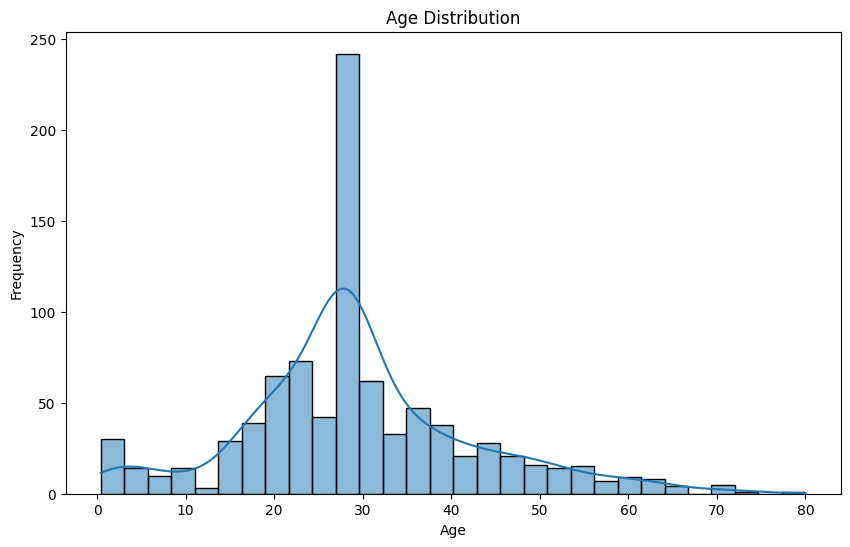

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


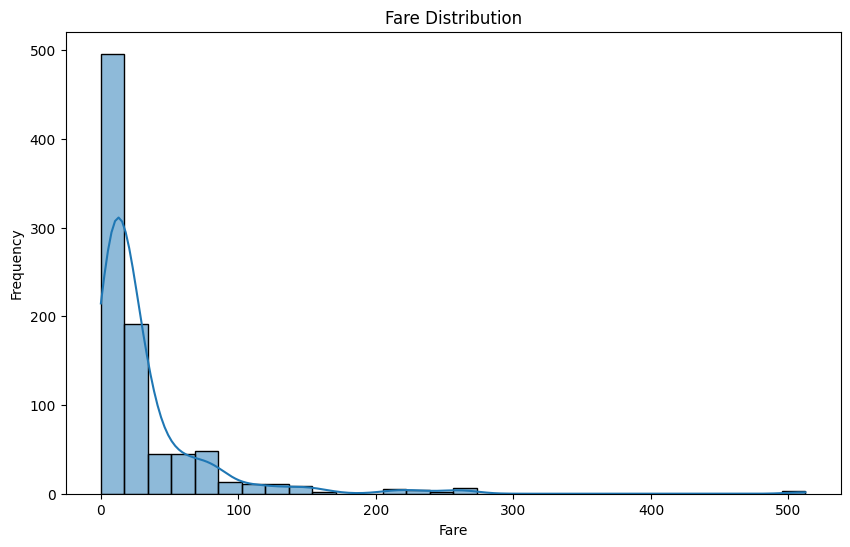

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Fare'], bins=30, kde=True)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

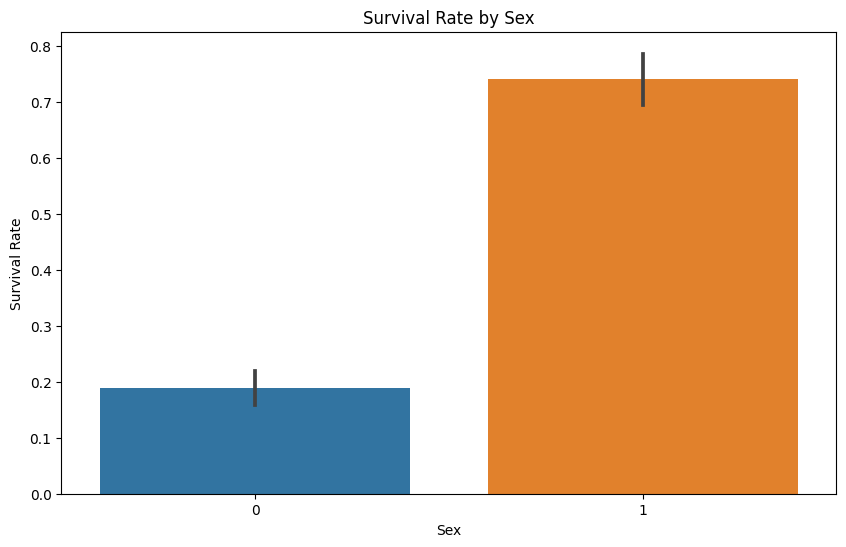

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

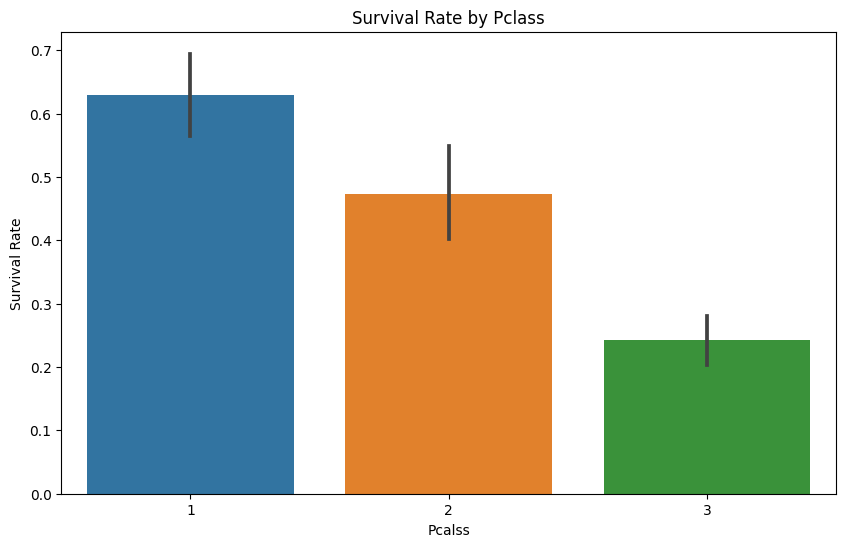

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Pclass')
plt.xlabel('Pcalss')
plt.ylabel('Survival Rate')
plt.show()

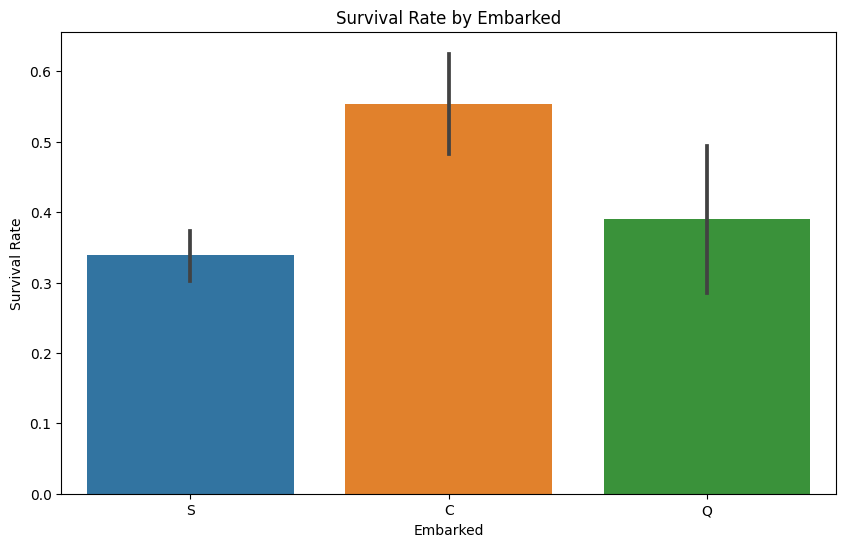

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x='Embarked', y='Survived', data=train_data)
plt.title('Survival Rate by Embarked')
plt.xlabel('Embarked')
plt.ylabel('Survival Rate')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

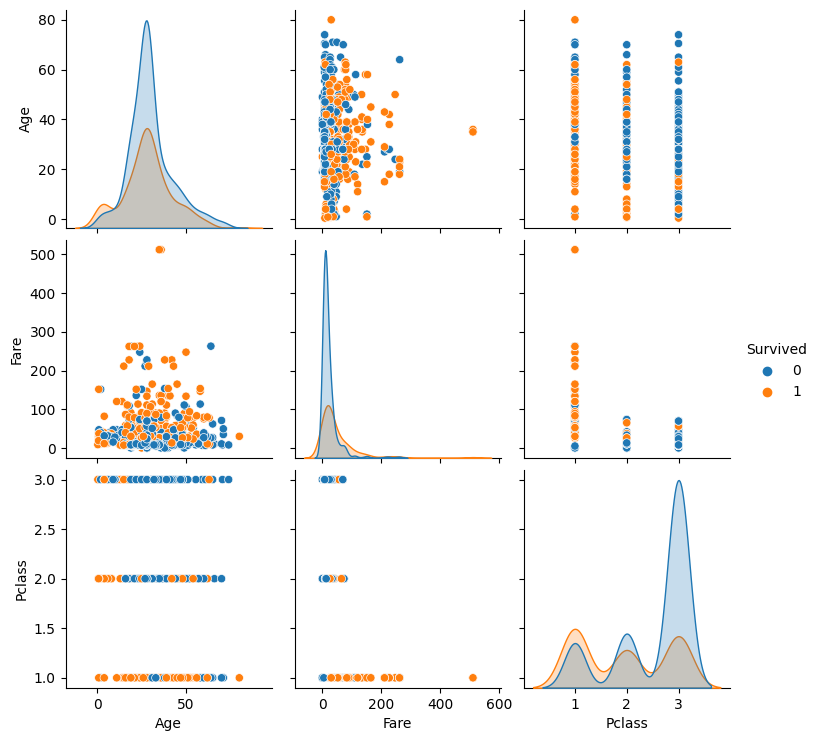

In [27]:
sns.pairplot(train_data[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived', diag_kind='kde')
plt.show()

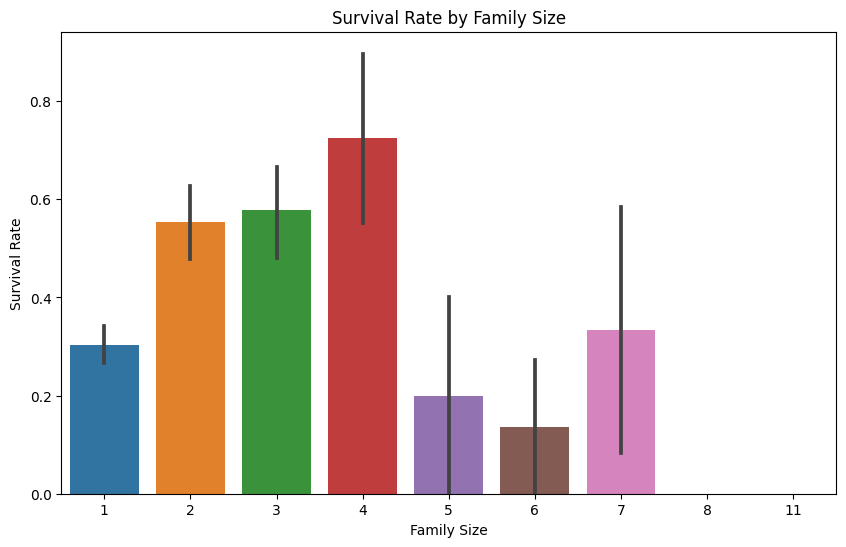

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=train_data)
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

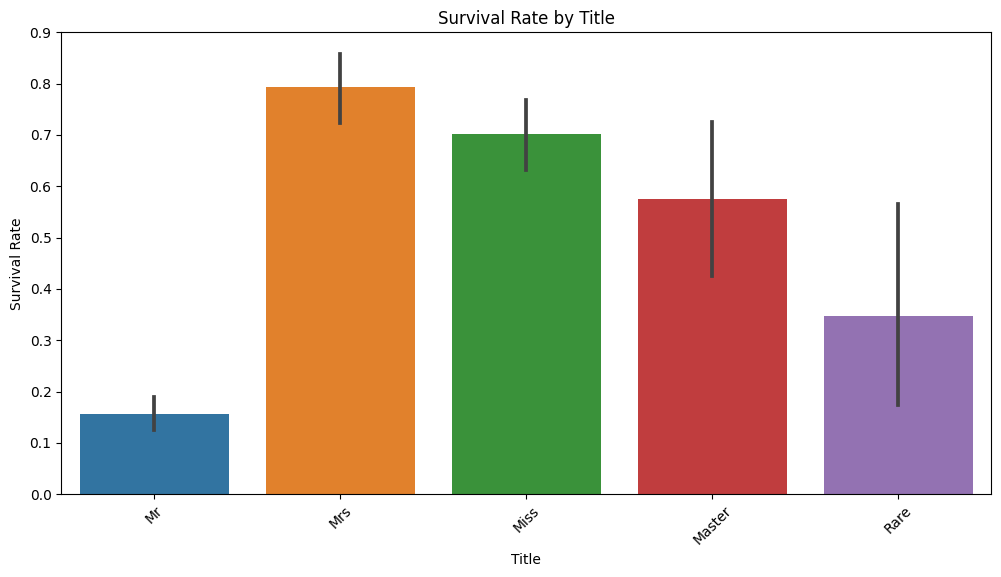

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Title', y='Survived', data=train_data)
plt.title('Survival Rate by Title')
plt.xlabel('Title')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()